Selected modalities:
1. mRNA - gene expression at the transcript level, often strongly associated with prognosis
2. proteome - protein abundance per gene, captures pathway activation and disease state
3. scna - somatic copy number alterations per gene (changes in the number of copies of DNA segments - deletions, apmlifications), changes the level of protein gene encodes

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

mrna_data = pd.read_csv('./PDAC_data/mRNA.csv') 
proteome_data = pd.read_csv('./PDAC_data/proteome_gene.csv') 
scna_data = pd.read_csv('./PDAC_data/SCNA_gene.csv')  

print("Before filtering:", len(mrna_data.columns), len(proteome_data.columns), len(scna_data.columns))

Before filtering: 138 138 138


### Only leave in common cases for all modalities

In [20]:
cases = []

for modality in [mrna_data, proteome_data, scna_data]: 
    cases.extend(modality.columns[1:].tolist())

cases = set(cases)
cases = sorted(cases)

mrna_data = mrna_data[['Unnamed: 0'] + list(cases)]
proteome_data = proteome_data[['Unnamed: 0'] + list(cases)] 
scna_data = scna_data[['Unnamed: 0'] + list(cases)] 
print("After filtering:", len(mrna_data.columns) - 1, len(proteome_data.columns) - 1, len(scna_data.columns) - 1)

After filtering: 137 137 137


### Preprocessing mRNA data

In [21]:
mrna_data.head()

,Unnamed: 0,C3L-00017,C3L-00102,C3L-00189,C3L-00277,C3L-00401,C3L-00589,C3L-00598,C3L-00599,C3L-00622,...,C3N-03780,C3N-03839,C3N-03840,C3N-03853,C3N-03884,C3N-04119,C3N-04126,C3N-04282,C3N-04283,C3N-04284
0,A1BG,6.344382,7.121994,6.910360,5.832438,7.196042,6.560635,5.147354,6.080283,6.869382,...,6.460347,5.905422,5.963758,5.239910,5.417659,6.479335,6.324574,6.159660,6.259811,6.275192
1,A1BG-AS1,4.963586,5.486881,6.796247,4.163636,5.217711,5.604399,4.590925,6.038171,6.134893,...,5.725175,5.868140,5.921989,4.839215,5.521989,6.660814,6.273918,6.123135,5.568870,4.858544
2,A1CF,8.019403,8.954949,7.224383,6.229405,7.703787,8.581375,4.433347,8.828935,8.218627,...,8.789258,7.110125,8.383515,9.390778,6.421686,7.390324,8.743371,5.874011,6.627052,11.212567
3,A2M,14.929271,15.423640,15.370481,14.378005,15.218920,15.006180,14.639205,14.732494,15.074692,...,15.670075,14.731175,15.282020,15.188164,15.543460,15.265415,14.972521,14.685338,13.754948,14.793454
4,A2M-AS1,7.417178,6.575599,7.810140,6.413674,8.571668,6.764586,7.072991,7.774834,7.231872,...,7.773370,7.319747,7.155470,6.087388,6.102337,6.916383,7.453673,6.592302,6.074993,6.971837


In [22]:
mrna_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
C3L-00017,28057.0,6.159108,4.400102,0.0,1.570596,7.002041,9.967226,21.399290
C3L-00102,28057.0,6.221008,4.397296,0.0,1.586128,7.082021,9.967226,21.448342
C3L-00189,28057.0,6.300179,4.335061,0.0,2.023764,7.171676,9.967226,21.724019
C3L-00277,28057.0,6.103461,4.480919,0.0,0.988201,6.917410,9.967226,21.289537
C3L-00401,28057.0,6.168787,4.452680,0.0,1.018717,7.036169,9.967226,22.486215


In [23]:
mrna_data.iloc[:, 1:].isna().sum(axis=1).sum()

np.int64(0)

In [24]:
mrna_data = mrna_data.T  # Transpose to have genes as features and patients as samples
mrna_data.columns = mrna_data.iloc[0]
mrna_data = mrna_data.iloc[1:]
mrna_data.head(1)

Unnamed: 0,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C3L-00017,6.344382,4.963586,8.019403,14.929271,7.417178,2.300882,3.291817,0.990936,7.458161,8.149458,...,8.944733,8.786904,9.147333,9.757941,10.903083,5.709591,11.404904,10.87494,11.477569,10.833993


In [25]:
genes_to_keep = 1500

print("Before feature selection:", mrna_data.shape)

variances = mrna_data.var(axis=0)
top_genes = variances.sort_values(ascending=False).head(genes_to_keep).index
mrna_data = mrna_data.loc[:, top_genes]

print("After feature selection:", mrna_data.shape)

Before feature selection: (137, 28057)
After feature selection: (137, 1500)


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
mrna_data = pd.DataFrame(
    scaler.fit_transform(mrna_data),
    columns=mrna_data.columns,
    index=mrna_data.index
)
mrna_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,,,,,,,,
XIST,137.0,-3.371188e-16,1.00367,-1.334001,-0.931651,-0.595182,1.035227,1.218374
PNLIP,137.0,-7.860703e-16,1.00367,-1.774577,-0.820381,0.023233,0.941292,1.867522
AMY2A,137.0,9.173522e-16,1.00367,-1.690260,-0.872577,-0.129081,1.013165,1.976782
RNA18SN4,137.0,-2.333899e-16,1.00367,-2.233742,-0.458966,0.302695,0.612667,1.564429
RNA18SN1,137.0,-2.333899e-16,1.00367,-2.233742,-0.458966,0.302695,0.612667,1.564429


### Preprocessing Proteome data

In [27]:
proteome_data.head()

,Unnamed: 0,C3L-00017,C3L-00102,C3L-00189,C3L-00277,C3L-00401,C3L-00589,C3L-00598,C3L-00599,C3L-00622,...,C3N-03780,C3N-03839,C3N-03840,C3N-03853,C3N-03884,C3N-04119,C3N-04126,C3N-04282,C3N-04283,C3N-04284
0,A1BG,28.601486,28.844697,29.095331,30.154566,27.945039,28.860579,29.304723,29.475239,28.169027,...,28.268168,28.595617,28.434823,28.752658,28.392768,28.599178,28.447192,28.845881,29.001208,27.371825
1,A1CF,22.910654,22.992885,22.915704,23.340567,23.437183,23.561795,23.096600,23.931338,23.145892,...,23.051569,22.694738,23.343972,23.632100,23.551903,23.087950,24.157361,22.797497,23.877868,24.705607
2,A2M,30.234863,30.927842,29.913937,30.193485,29.475057,30.253281,29.584493,29.625887,29.177603,...,29.758464,28.812635,30.185272,29.739092,29.172591,29.236857,29.716579,29.265823,29.962177,28.600494
3,A2ML1,19.998060,21.556027,22.207543,19.781709,22.198512,NaN,25.751913,NaN,21.980613,...,22.060531,20.675564,22.199821,20.888357,NaN,22.872600,24.402056,22.606844,22.657078,21.582641
4,A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.885426,NaN,NaN,14.997706,NaN,16.257520,NaN


In [28]:
proteome_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
C3L-00017,9043.0,23.773076,2.895226,12.332300,22.052750,23.885127,25.649955,33.914954
C3L-00102,9127.0,23.761056,2.755669,12.381958,22.102814,23.856396,25.517110,34.578411
C3L-00189,8903.0,23.896131,2.671505,12.510941,22.258724,23.931192,25.604862,34.967399
C3L-00277,8245.0,24.206965,2.687810,12.672711,22.555293,24.150312,25.883275,35.094199
C3L-00401,8798.0,23.905841,2.654841,12.547400,22.317088,23.965424,25.601260,32.793156


In [29]:
proteome_data.iloc[:, 1:].isna().sum(axis=1).sum()

np.int64(392380)

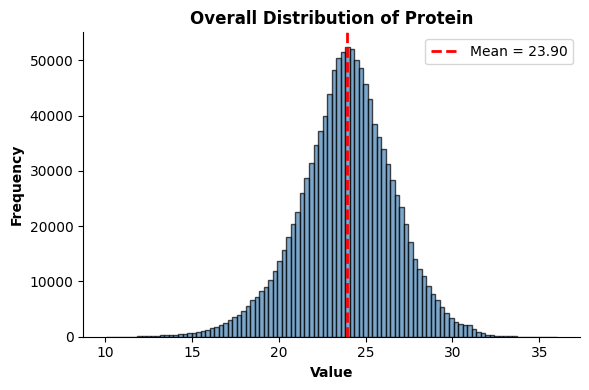

In [30]:
proteome_values = proteome_data.iloc[:, 1:].values.flatten()
proteome_values_no_nan = proteome_values[~np.isnan(proteome_values)]

plt.figure(figsize=(6, 4))
plt.hist(
    proteome_values_no_nan, bins=100, edgecolor='black', 
    alpha=0.7, color='steelblue'
)
plt.xlabel('Value', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Overall Distribution of Protein', fontweight='bold')
plt.axvline(
    proteome_values_no_nan.mean(), color='red', linestyle='--', 
    linewidth=2, label=f'Mean = {proteome_values_no_nan.mean():.2f}'
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.tight_layout()
plt.show()


Remove proteins if detected in less than 30% of samples

In [31]:
print("Before filtering:", proteome_data.shape, "Missing values:", proteome_data.iloc[:, 1:].isna().sum(axis=1).sum())

n_samples = proteome_data.shape[1] - 1
threshold = int(n_samples * 0.3)

missing_proteins = proteome_data.iloc[:, 1:].isna().sum(axis=1)
detected_proteins = n_samples - missing_proteins
proteome_data = proteome_data[detected_proteins >= threshold]

print("After filtering:", proteome_data.shape, "Missing values:", proteome_data.iloc[:, 1:].isna().sum(axis=1).sum())

Before filtering: (11662, 138) Missing values: 392380
After filtering: (9644, 138) Missing values: 153178


Impute missing values with a value less than a minimum of the values for each protein 

(this seems like a correct way to impute data for proteomics from what I've read)

In [32]:
offset = 1.8 # data seems log-transformed, so I'm adding a small offset to the minimum value
min_values_per_protein = proteome_data.iloc[:, 1:].min(axis=1) - offset
proteome_data.iloc[:, 1:] = proteome_data.iloc[:, 1:].T.fillna(min_values_per_protein).T
print("Missing values:", proteome_data.isna().sum().sum())

Missing values: 0


In [33]:
proteome_data = proteome_data.T  # Transpose to have genes as features and patients as samples
proteome_data.columns = proteome_data.iloc[0]
proteome_data = proteome_data.iloc[1:]
proteome_data.head(1)

Unnamed: 0,A1BG,A1CF,A2M,A2ML1,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,...,ZRANB2,ZRSR2,ZSCAN18,ZSWIM8,ZW10,ZWILCH,ZYG11B,ZYX,ZZEF1,ZZZ3
C3L-00017,28.601486,22.910654,30.234863,19.99806,22.536314,24.688855,19.821161,23.48473,24.56114,26.319347,...,26.660606,15.222905,22.708525,21.925598,24.801234,17.788874,20.735222,28.015323,24.232404,19.255924


In [34]:
proteome_data.shape

(137, 9644)

In [35]:
scaler = StandardScaler()

proteome_data = pd.DataFrame(
    scaler.fit_transform(proteome_data),
    columns=proteome_data.columns,
    index=proteome_data.index
)
proteome_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,,,,,,,,
A1BG,137.0,-5.957927e-15,1.00367,-2.478275,-0.679812,-0.098256,0.561794,3.549762
A1CF,137.0,2.088516e-14,1.00367,-3.056458,-0.603328,-0.094324,0.599393,2.476630
A2M,137.0,4.590002e-15,1.00367,-2.788624,-0.655710,-0.018575,0.598954,3.003327
A2ML1,137.0,1.698560e-15,1.00367,-1.692320,-0.429660,0.141572,0.617864,2.493224
AAAS,137.0,-6.016274e-15,1.00367,-3.828169,-0.592665,-0.100244,0.557912,2.706605


In [36]:
proteome_data.head(1)

Unnamed: 0,A1BG,A1CF,A2M,A2ML1,AAAS,AACS,AADAC,AAGAB,AAK1,AAMDC,...,ZRANB2,ZRSR2,ZSCAN18,ZSWIM8,ZW10,ZWILCH,ZYG11B,ZYX,ZZEF1,ZZZ3
C3L-00017,0.185445,-0.592399,0.964998,-0.543458,-0.727576,1.512089,-0.475572,-0.361871,-0.994617,1.43181,...,0.322185,-0.670025,0.716651,0.246046,0.881191,-1.408678,0.26554,-1.48282,-0.977116,0.431648


### Preprocessing SCNA data

In [37]:
scna_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
C3L-00017,19892.0,-0.003686,0.135662,-0.24996,-0.02511,-0.00174,0.00172,2.49556
C3L-00102,19891.0,0.000622,0.052212,-0.24747,-0.02754,-0.00445,0.01704,0.57177
C3L-00189,19892.0,-0.000217,0.019327,-0.19589,-0.00645,0.00706,0.00927,0.10593
C3L-00277,19889.0,-0.014423,0.162939,-0.82827,-0.05609,-0.04802,0.04053,0.52696
C3L-00401,19892.0,-0.003705,0.020642,-0.04635,-0.01500,-0.01030,0.00342,0.22784


In [38]:
print('Missing values:', scna_data.isna().sum(axis=1).sum())

Missing values: 2091


In [39]:
# For SCNA, imputing missing values with 0 

scna_data = scna_data.fillna(0)
print('Missing values:', scna_data.isna().sum(axis=1).sum())

Missing values: 0


In [40]:
scna_data = scna_data.T  # Transpose to have genes as features and patients as samples
scna_data.columns = scna_data.iloc[0]
scna_data = scna_data.iloc[1:]
scna_data.head(1)

Unnamed: 0,OR4F29,OR4F16,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,...,PRY,BPY2,DAZ1,DAZ2,CDY1B,BPY2B,DAZ3,DAZ4,BPY2C,CDY1
C3L-00017,0.07577,0.07577,0.07577,0.07577,0.07577,0.07577,0.07577,0.07577,0.07577,0.07577,...,0.66497,0.66497,0.66497,0.66497,0.66497,0.66497,0.66497,0.66497,0.66497,0.66497


In [41]:
genes_to_keep = 3000

print("Before feature selection:", scna_data.shape)

variances = scna_data.var(axis=0)
top_genes = variances.sort_values(ascending=False).head(genes_to_keep).index
scna_data = scna_data.loc[:, top_genes]

print("After feature selection:", scna_data.shape)

Before feature selection: (137, 19906)
After feature selection: (137, 3000)


In [42]:
scaler = StandardScaler()

scna_data = pd.DataFrame(
    scaler.fit_transform(scna_data),
    columns=scna_data.columns,
    index=scna_data.index
)
scna_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,,,,,,,,
IL3RA,137.0,5.186443e-17,1.00367,-1.720376,-0.211606,-0.044951,0.022769,10.428958
VCY,137.0,2.917374e-17,1.00367,-2.608925,-0.515673,0.014767,0.467535,5.309140
UTY,137.0,-3.889832e-17,1.00367,-2.872264,-0.528820,0.061155,0.567705,2.474303
USP9Y,137.0,-3.889832e-17,1.00367,-2.872264,-0.528820,0.061155,0.567705,2.474303
DDX3Y,137.0,-3.889832e-17,1.00367,-2.872264,-0.528820,0.061155,0.567705,2.474303


In [43]:
print(mrna_data.shape, proteome_data.shape, scna_data.shape)

mrna_data = mrna_data.sort_index()
proteome_data = proteome_data.sort_index()
scna_data = scna_data.sort_index()

mrna_data.to_csv('./PDAC_data/mRNA_preprocessed.csv', index=True)
proteome_data.to_csv('./PDAC_data/proteome_preprocessed.csv', index=True)
scna_data.to_csv('./PDAC_data/SCNA_preprocessed.csv', index=True)

(137, 1500) (137, 9644) (137, 3000)
